In this notebook, we implement the Deutsch-Jozsa algorithm using Qiskit. Recall that the algorithm is figuring out whether a given binary function
$$
f \colon \{0,1\}^n \rightarrow \{0,1\}
$$
is balanced or constant. So let us first choose a reasonably simple function f and implement the corresponding oracle. Basically the easiest choice is probably $n = 2$ and
$$
f(x_0, x_1) = x_0 \oplus x_1
$$
What is the oracle $U_f$? The oracle is specified by
$$
U_f |x \rangle |y \rangle = |x \rangle |y \oplus f(x) \rangle
$$
So the third qubit is inverted if f is equal to one and left unchanged otherwise. Using the definition of f, we see that the third qubit is inverted if the first two qubits are different and left unchanged if they are equal.
This is easily implemented using two CNOT gates

In [1]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.tools.visualization import matplotlib_circuit_drawer as drawer
from qiskit.tools.visualization import plot_histogram
from qiskit import Aer
from qiskit import compile, execute
from qiskit import IBMQ
import numpy as np
%matplotlib inline
my_style = {'cregbundle': True}

In [2]:
#####################################
# Create the oracle. We assume that #
# our quantum register has three    #
# qubits.                           #
#####################################
def createOracleBalanced(q,c):
    circuit = QuantumCircuit(q,c)
    circuit.cx(q[0], q[2])
    circuit.cx(q[1], q[2])
    circuit.barrier(q)
    return circuit



#####################################
# Create a constant oracle          #
#####################################
def createOracleConstant(q,c):
    circuit = QuantumCircuit(q,c)
    circuit.x(q[2])
    circuit.barrier(q)
    return circuit

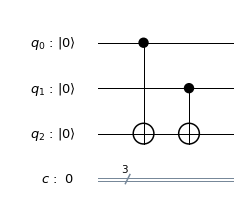

In [3]:
#
# Try it out
#
q = QuantumRegister(3,"q")
c = ClassicalRegister(3,"c")
circuit = createOracleBalanced(q,c)
drawer(circuit, style = my_style)

In [4]:
backend = Aer.get_backend('unitary_simulator') 
job = execute(circuit, backend)
#
# Print this as truth table
# 
for i in range(2**2):
    out = job.result().get_unitary()
    print("|", format(i, '03b'),"> --->> |", format(np.argmax(out.T[i]), '03b'),">")

| 000 > --->> | 000 >
| 001 > --->> | 101 >
| 010 > --->> | 110 >
| 011 > --->> | 011 >


Now we get to the actual Deutsch-Jozsa algorithm. We use the version of the algorithm described in https://arxiv.org/abs/quant-ph/9708016. Here, the first step is to create the usual superposition state
$$
|\psi \rangle = \frac{1}{2} \sum_x |x \rangle
$$
We know how to do this - we start with the fiducial state and apply a Hadamard gate to every qubit.

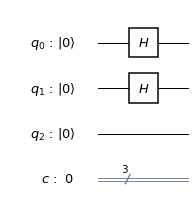

In [5]:
def createInitialState(circuit):
    circuit.h(q[0])
    circuit.h(q[1])
    circuit.barrier(q)

    
q = QuantumRegister(3,"q")
c = ClassicalRegister(3,"c")
circuit = QuantumCircuit(q,c)
createInitialState(circuit)
drawer(circuit, style = my_style)

Next, we add an ancilla qubit that we initialize to one and apply the Hadamard to this ancilla qubit. The result will be the state
$$
|\psi \rangle = \frac{1}{2\sqrt{2}} \sum_x  |x , 0 \rangle - |x, 1 \rangle 
$$

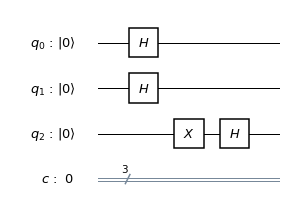

In [6]:
def addAncilla(circuit):
    circuit.x(q[2])
    circuit.h(q[2])
    circuit.barrier(q)

addAncilla(circuit)
drawer(circuit, style = my_style)

Next we add $U_f$ to the circuit. This will result in the state
$$
\frac{1}{\sqrt{2^n}}  (\sum_x (-1)^{f(x)} |x\rangle) \otimes H|1\rangle   
$$

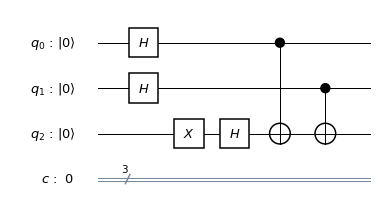

In [7]:
circuit = circuit + (createOracleBalanced(q,c))
circuit.barrier(q)
drawer(circuit, style = my_style)

Next, we uncompute the ancillary qubit - we apply another Hadamard followed by a Pauli X gate. This will give us the state
$$
\frac{1}{\sqrt{2^n}}  (\sum_x (-1)^{f(x)} |x\rangle) \otimes |0\rangle   
$$

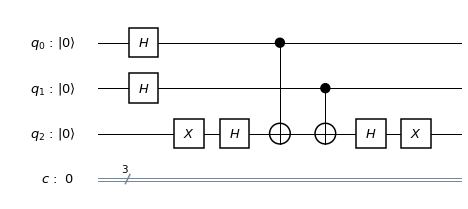

In [8]:
def uncomputeAncilla(circuit):
    circuit.h(q[2])
    circuit.x(q[2])
    circuit.barrier(q)
    
uncomputeAncilla(circuit)
drawer(circuit, style = my_style)

Finally, to return to the standard basis, we apply Hadamard gates on the first two qubits. We then measure the result.

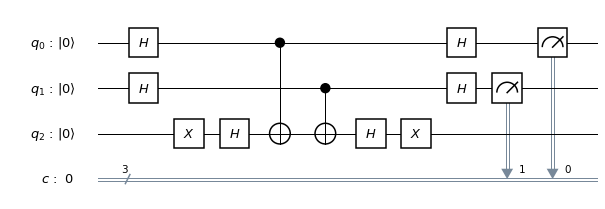

In [9]:
def addMeasurement(circuit):
    circuit.h(q[0])
    circuit.h(q[1])
    circuit.barrier(q)
    circuit.measure(q[0], c[0])
    circuit.measure(q[1], c[1])
    circuit.barrier(q)
    
addMeasurement(circuit)
drawer(circuit, style = my_style)

In [10]:
#
# Now we are ready to execute the full circuit
#
IBMQ.load_accounts()
backend = IBMQ.get_backend('ibmqx4') 
#backend = IBMQ.get_backend('ibmq_16_melbourne') 
#backend = IBMQ.get_backend('ibmq_qasm_simulator') 
#backend = Aer.get_backend("qasm_simulator")
print("Status of backend: ", backend.status())
#
# Now we compile
#
from qiskit import compile
qobj = compile(circuit, backend=backend, shots=1024)
#
# and submit as a job
#
job = backend.run(qobj)

Status of backend:  {'pending_jobs': 8, 'name': 'ibmqx4', 'operational': True}


In [11]:
import time
lapse = 0
#
# Wait three seconds once, this should be good enough for the simulator in most cases
#
time.sleep(3)
interval = 60
while (job.status().name != 'DONE') and (job.status().name != 'CANCELLED') and (job.status().name != 'ERROR'):
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    print("Position in queue: ",job.queue_position())
    time.sleep(interval)
    lapse += 1
print(job.status())

Status @ 0 seconds
JobStatus.INITIALIZING
Position in queue:  None
Status @ 60 seconds
JobStatus.QUEUED
Position in queue:  7
Status @ 120 seconds
JobStatus.QUEUED
Position in queue:  4
Status @ 180 seconds
JobStatus.QUEUED
Position in queue:  4
Status @ 240 seconds
JobStatus.QUEUED
Position in queue:  3
Status @ 300 seconds
JobStatus.RUNNING
Position in queue:  0
JobStatus.DONE


In [12]:
result = job.result()
counts = result.get_counts()
counts

{'000': 72, '001': 133, '010': 113, '011': 706}

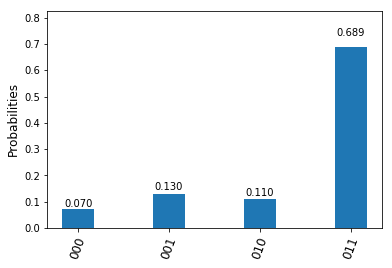

In [13]:
#
# Plot this
#
plot_histogram(counts)

Finally let us interpret the result. We know that there are two cases. If the function is balanced, the probability to measure 00 is zero. If the function is not balanced, it will be one. 

In [14]:
if '000' in counts:
    zeroMeasurements = counts['000']
else:
    zeroMeasurements = 0
if (zeroMeasurements < 100):
    print("Function is balanced")
else:
    print("Function is constant")

Function is balanced


Now we repeat the entire exercise with a constant function.

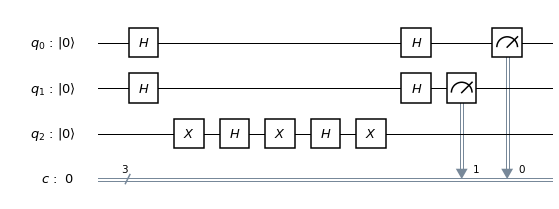

In [15]:
q = QuantumRegister(3,"q")
c = ClassicalRegister(3,"c")
circuit = QuantumCircuit(q,c)
createInitialState(circuit)
addAncilla(circuit)
circuit = circuit + (createOracleConstant(q,c))
uncomputeAncilla(circuit)
addMeasurement(circuit)
drawer(circuit, style = my_style)

In [16]:
qobj = compile(circuit, backend=backend, shots=1024)
job = backend.run(qobj)

In [17]:
import time
lapse = 0
#
# Wait three seconds once, this should be good enough for the simulator in most cases
#
time.sleep(3)
interval = 60
while (job.status().name != 'DONE') and (job.status().name != 'CANCELLED') and (job.status().name != 'ERROR'):
    print('Status @ {} seconds'.format(interval * lapse))
    print(job.status())
    print("Position in queue: ",job.queue_position())
    time.sleep(interval)
    lapse += 1
print(job.status())

Status @ 0 seconds
JobStatus.QUEUED
Position in queue:  6
Status @ 60 seconds
JobStatus.QUEUED
Position in queue:  5
Status @ 120 seconds
JobStatus.QUEUED
Position in queue:  4
Status @ 180 seconds
JobStatus.QUEUED
Position in queue:  1
JobStatus.DONE


In [18]:
result = job.result()
counts = result.get_counts()
counts

{'000': 930, '001': 46, '010': 45, '011': 3}

In [19]:
if '000' in counts:
    zeroMeasurements = counts['000']
else:
    zeroMeasurements = 0
if (zeroMeasurements < 100):
    print("Function is balanced")
else:
    print("Function is constant")

Function is constant


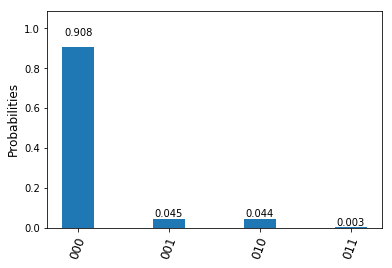

In [20]:
plot_histogram(counts)